# 信用卡欺诈判别

本文以kaggle上的Credit Card Fraud Detection为学习对象，利用XGBoost、Logistic Regression、Random Forest方法对信用卡欺诈进行识别，并将这三种模型的结果通过投票的方式进行聚合得到最终的结果。

## 1. 加载库并读入数据

### 1.1 加载库

In [1]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from __future__ import division
import warnings

# 忽略告警
warnings.filterwarnings('ignore') 

### 1.2 读入数据

In [2]:
data = pd.read_csv('./data/creditcard.csv')

## 2. 数据探索与分析

数据集包含欧洲持卡人于2013年9月通过信用卡进行的交易。该数据集提供两天内发生的交易，其中在284,807笔交易中有492起欺诈行为。数据集非常不平衡，负面类别（欺诈）占所有交易的0.172％。

数据经过PCA降维，特征V1,V2,...,V28是PCA获得的主要组件，还有交易时间Time、交易金额Amount。每条记录有一个Class，值为1时表示信用卡诈骗（正例），0表示正常消费（负例）。

### 2.1 变量分布和描述

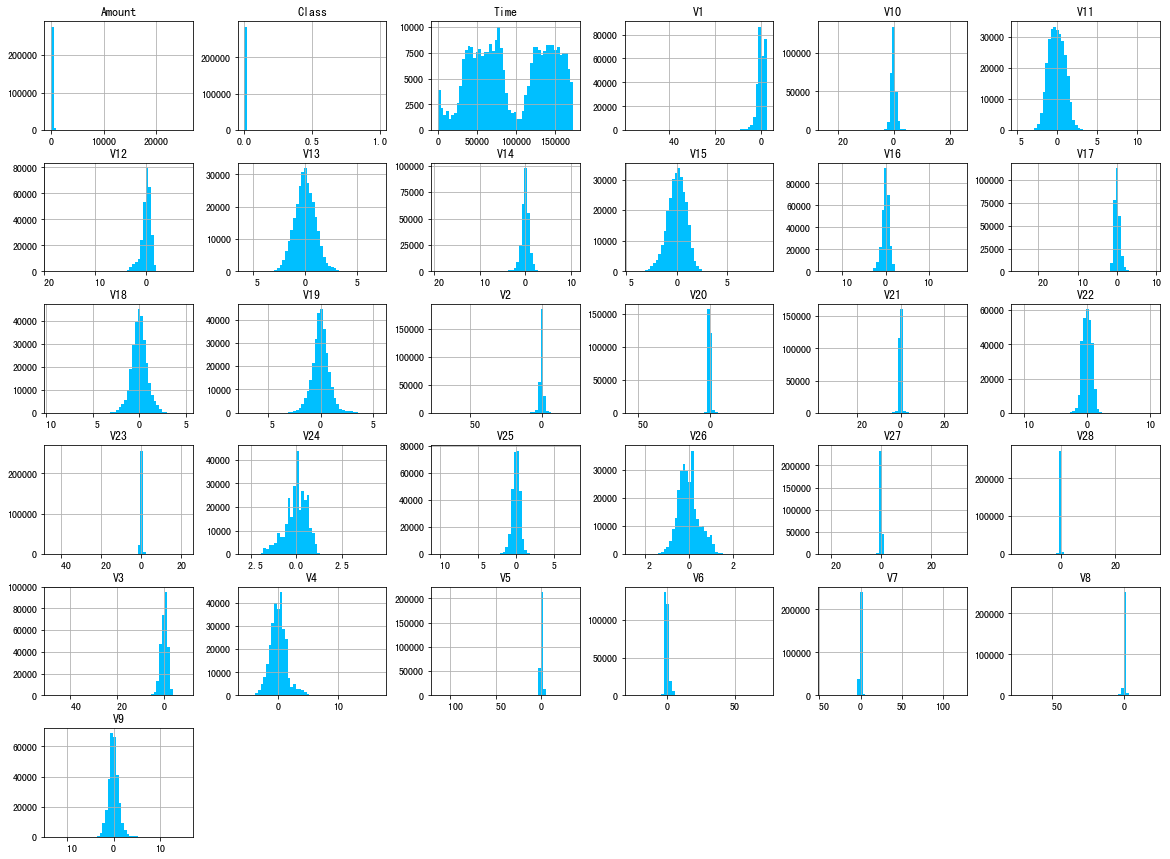

In [3]:
data.hist (bins=50, figsize=(20,15), color = 'deepskyblue')

plt.show()

In [10]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 2.2 类别分布

数据集非常不平衡，正例（欺诈）数量占全部交易量的0.172%。

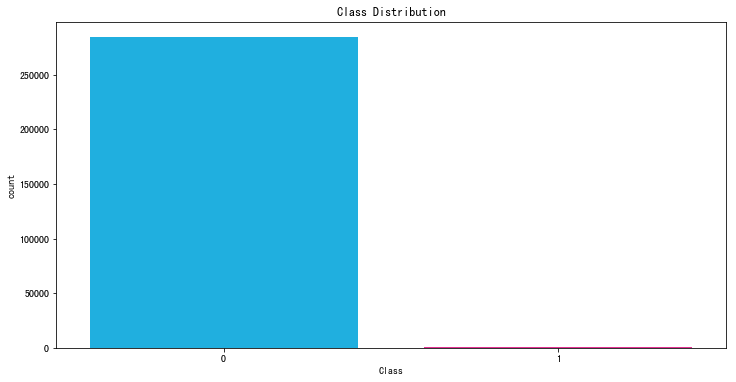

% of normal transacation       :99.827
('Number of normal transaction   :', 284315)
% of fraud transacation        :0.173
('Number of fraud transaction    :', 492)


In [15]:
my_pal = {0: 'deepskyblue', 1: 'deeppink'}

plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'Class', data = data, palette = my_pal)
plt.title('Class Distribution')
plt.show()

# 正常交易量和欺诈交易量以及百分比
Count_Normal_transacation = len(data[data['Class']==0])
Count_Fraud_transacation = len(data[data['Class']==1]) 
Percentage_of_Normal_transacation = float(Count_Normal_transacation)/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of normal transacation       :{:.3f}'.format(Percentage_of_Normal_transacation*100))
print('Number of normal transaction   :', Count_Normal_transacation)
Percentage_of_Fraud_transacation= float(Count_Fraud_transacation)/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of fraud transacation        :{:.3f}'.format(Percentage_of_Fraud_transacation*100))
print('Number of fraud transaction    :', Count_Fraud_transacation)

### 2.3 时间和类别的关系

从时间上看，欺诈在交易活跃和交易少的时段都有发生，在交易很活跃时一些欺诈事件不易被发觉，而交易少的时段都是夜间，此时人们已休息，也易于作案。深夜时正常交易量和欺诈量都较少，此时人们可能都处在睡眠时间。

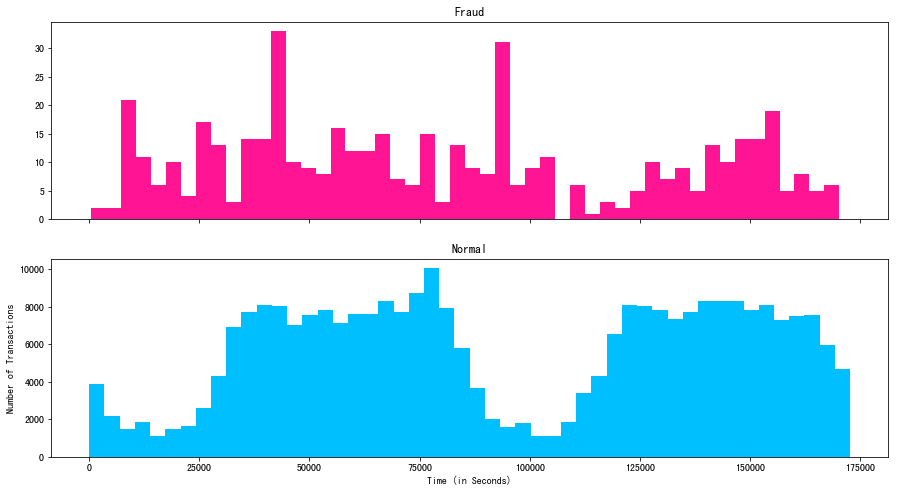

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins, color = 'deeppink')
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins, color = 'deepskyblue')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

### 2.4 时间、交易金额和类别的关系

从交易金额来看，大多数欺诈事件的欺诈金额较小，但也有不少欺诈金额在500+以上。

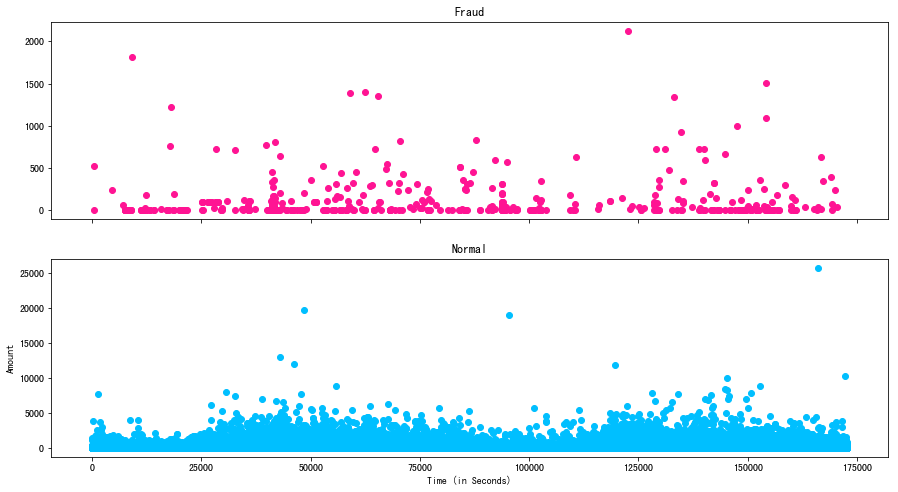

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))

ax1.scatter(data.Time[data.Class == 1], data.Amount[data.Class == 1], color = 'deeppink')
ax1.set_title('Fraud')

ax2.scatter(data.Time[data.Class == 0], data.Amount[data.Class == 0],  color = 'deepskyblue')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### 2.5 其它变量与类别的关系

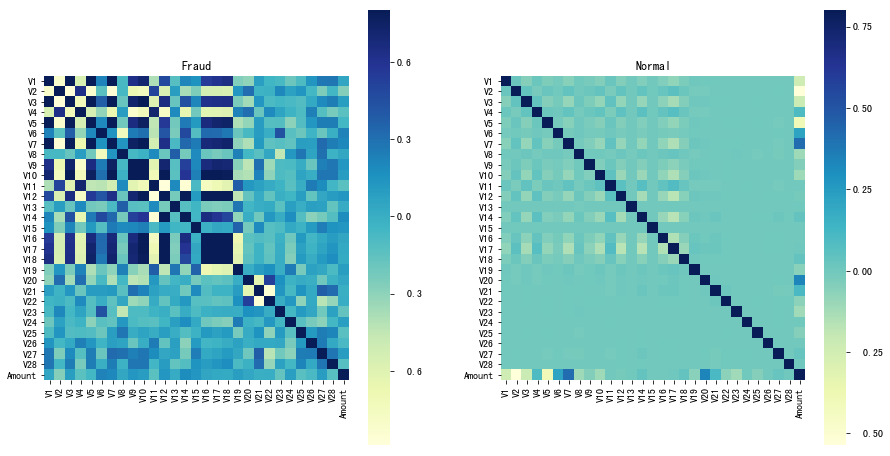

In [8]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 15, 8))

sns.heatmap(data.query('Class==1').drop(['Class','Time'],1).corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(data.query('Class==0').drop(['Class','Time'],1).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

## 3. 数据准备

### 3.1 划分训练集和测试集

训练集用来训练模型和参数调优，占90%。测试集用来评估模型性能，占10%。

In [4]:
# 把数据集划分为训练集和测试集，一个用来train(训练) & validation(调参)，另一个是test（评估模型）
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split (data, test_size = 0.1, random_state = 42)
data = train_set
test_data = test_set

### 3.2 交易金额Amount的归一化

In [5]:
# Amount归一化
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

查看归一化后的效果：

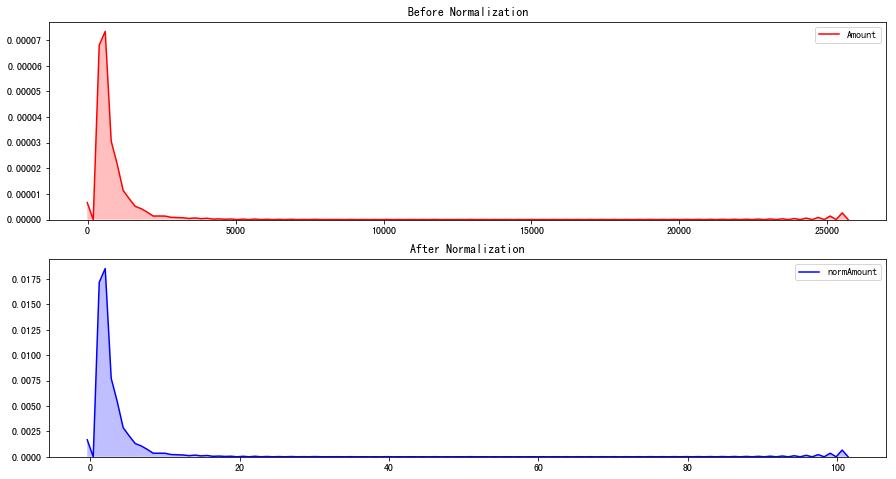

In [18]:
f, (ax1, ax2) = plt.subplots(2,1,figsize =( 15, 8))

sns.kdeplot(data['Amount'],shade=True, ax = ax1, color='red')
ax1.set_title('Before Normalization')

sns.kdeplot(data['normAmount'],shade=True, ax = ax2, color='blue')
ax2.set_title('After Normalization')

plt.show()

### 3.3 删除无用变量

In [6]:
data = data.drop(['Amount','Time'],axis=1)

检查数据：

In [20]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
count,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,...,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,256326.000000,2.563260e+05
mean,0.000787,0.000279,-0.000545,-0.000420,0.000217,0.000337,0.000506,0.000020,0.000775,-0.000852,...,0.000328,-0.000705,0.000241,0.000222,-0.000728,-0.000560,-0.000321,0.000216,0.001740,7.456754e-18
std,1.956494,1.648986,1.514006,1.415594,1.381680,1.333873,1.239372,1.192610,1.097865,1.086855,...,0.736526,0.725983,0.626604,0.605236,0.521304,0.482247,0.402277,0.329320,0.041677,1.000002e+00
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,0.000000,-3.501836e-01
25%,-0.920249,-0.598404,-0.890516,-0.848857,-0.690771,-0.768232,-0.552928,-0.208079,-0.642234,-0.535786,...,-0.228425,-0.542797,-0.161585,-0.354460,-0.317659,-0.327408,-0.070740,-0.052946,0.000000,-3.281995e-01
50%,0.018564,0.065501,0.179232,-0.019309,-0.054395,-0.274532,0.040901,0.022482,-0.050994,-0.093601,...,-0.029573,0.005660,-0.010801,0.040838,0.015092,-0.052788,0.001470,0.011339,0.000000,-2.630397e-01
75%,1.315616,0.804021,1.025290,0.743958,0.611975,0.398376,0.569886,0.327616,0.597900,0.452858,...,0.186277,0.528637,0.147998,0.439788,0.350571,0.240183,0.091141,0.078325,0.000000,-4.454612e-02
max,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,15.245686,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000,1.014147e+02


## 4. 定义评价指标

### 4.1 混淆矩阵

In [7]:
# 混淆矩阵绘图
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


### 4.2 Recall, Precision 和 F1_score

In [8]:
# 显示评估指标
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

### 4.3 Precision-Recall曲线

In [9]:
# 绘制 P-R 曲线
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

### 4.4 ROC 曲线

In [10]:
# 绘制 ROC 曲线
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

### 4.5 特征重要性

In [25]:
predictors = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Normamount']

绘制特征重要性的函数：

In [26]:
# 绘制特征重要性
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (15,8))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

### 4.6 定义（X,y）及交叉验证

In [12]:
# 定义 X 和 y
y = np.array(data.Class.tolist())
data = data.drop('Class', 1)
X = np.array(data.as_matrix())

# K 折交叉验证
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

# 检查数据
print X.shape
print X_train.shape
print X_test.shape

(256326, 29)
(205061, 29)
(51265, 29)


## 5. Logistic Regression (LOG)

### 5.1 LOG - 未调优超参数

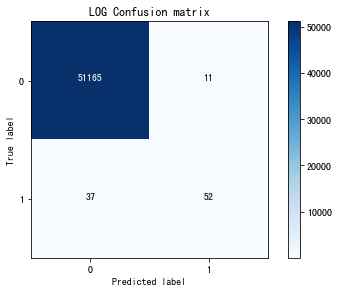

Precision =     0.825
Recall    =     0.584
F1_score  =     0.684


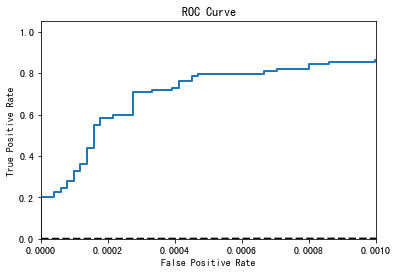

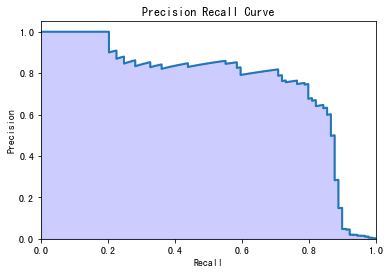

In [31]:
# 逻辑斯蒂回归
log_cfl = LogisticRegression()

log_cfl.fit(X_train, y_train)
y_pred = log_cfl.predict(X_test)
y_score = log_cfl.decision_function(X_test)  

# 混淆矩阵 & 评估指标
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'LOG Confusion matrix')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

In [32]:
# 查看当前参数
from pprint import pprint
print('Parameters currently in use:\n')
pprint(log_cfl.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### 5.2 LOG - GridSearchCV 搜索超参数

In [33]:
# 使用GridSearchCV找到最佳的参数组合
from sklearn.model_selection import GridSearchCV
param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.1, 1, 10, 100]
            }

CV_log_cfl = GridSearchCV(estimator = log_cfl, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log_cfl.fit(X_train, y_train)

best_parameters = CV_log_cfl.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.9min finished


('The best parameters for using this model is', {'penalty': 'l1', 'C': 0.1, 'class_weight': 'balanced'})


### 5.3 LOG - 超参数更新

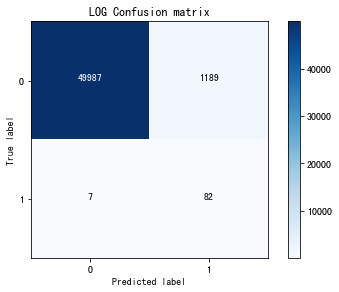

Precision =     0.065
Recall    =     0.921
F1_score  =     0.121


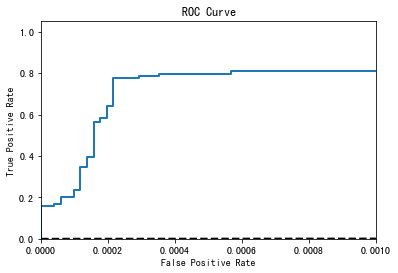

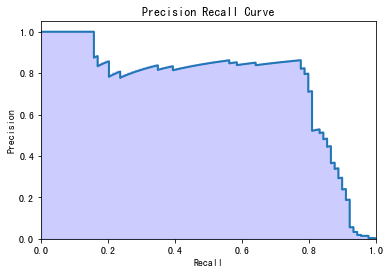

In [28]:
# 使用搜索的超参数组合重新构建模型，将结果可视化
log_cfl = LogisticRegression(C = 0.1, 
                             penalty = 'l1', 
                             class_weight = 'balanced')
log_cfl.fit(X_train, y_train)
y_pred = log_cfl.predict(X_test)
y_score = log_cfl.decision_function(X_test)

# 混淆矩阵 & 评估指标
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='LOG Confusion matrix')

plt.savefig('4.log_cfl_confusion_matrix.png')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_log, tpr_log, t_log = fpr, tpr, t
precision_log, recall_log, thresholds_log = precision, recall, thresholds

## 6. Extreme Gradient Boosting (XGB)

### 6.1 XGB - 未调优超参数

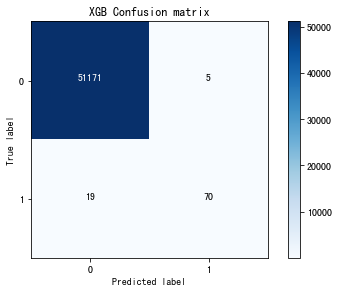

Precision =     0.933
Recall    =     0.787
F1_score  =     0.854


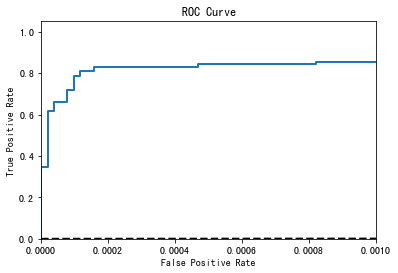

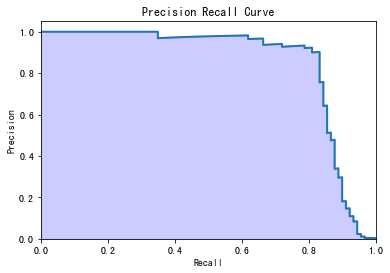

In [40]:
# xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)

xgb_cfl.fit(X_train, y_train)
y_pred = xgb_cfl.predict(X_test)
y_score = xgb_cfl.predict_proba(X_test)[:,1]

# 混淆矩阵 & 评估指标
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='XGB Confusion matrix')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

### 6.2 XGB - GridSearchCV 搜索超参数

In [39]:
# 使用 GridSearchCV 搜索 XGB 超参数
param_grid = {
            'n_estimators': [100, 200, 300, 400]
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='f1', verbose = 2, n_jobs = -1)
CV_xgb_cfl.fit(X_train, y_train)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.5min finished


('The best parameters for using this model is', {'n_estimators': 200})


### 6.3 XGB - 超参数更新

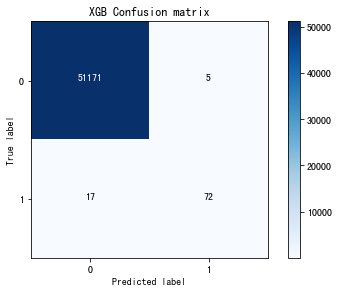

Precision =     0.935
Recall    =     0.809
F1_score  =     0.867


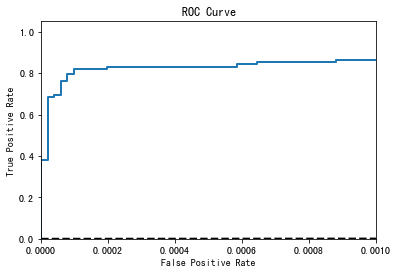

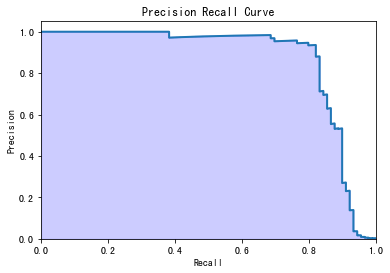

In [29]:
# xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1, 
                            n_estimators = 200)

xgb_cfl.fit(X_train, y_train)
y_pred = xgb_cfl.predict(X_test)
y_score = xgb_cfl.predict_proba(X_test)[:,1]

# 混淆矩阵 & 评估指标
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'XGB Confusion matrix')
plt.savefig('2.xgb_cfl_confusion_matrix.png')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_xgb, tpr_xgb, t_xgb = fpr, tpr, t
precision_xgb, recall_xgb, thresholds_xgb = precision, recall, thresholds

对特征重要程度进行可视化：

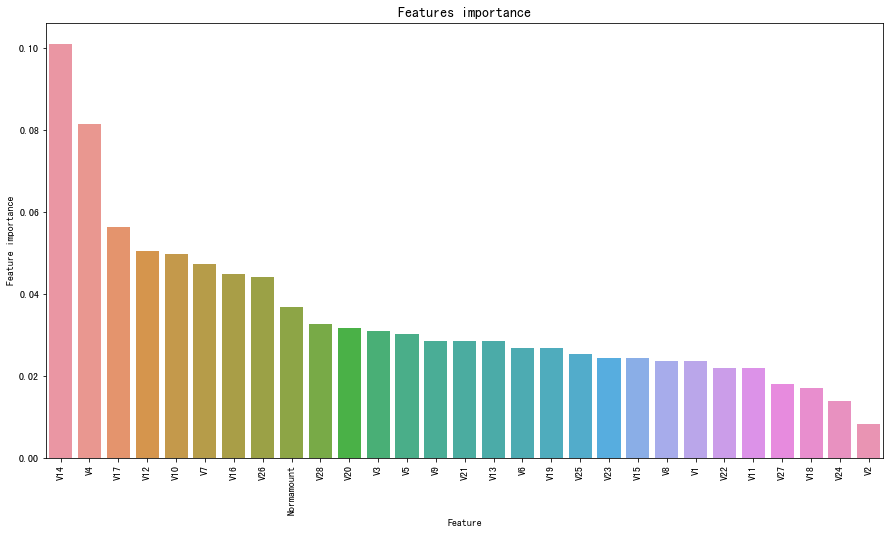

In [42]:
plot_feature_importance(xgb_cfl)

## 7. Random Forest (RF)

### 7.1 RF - 未调优超参数

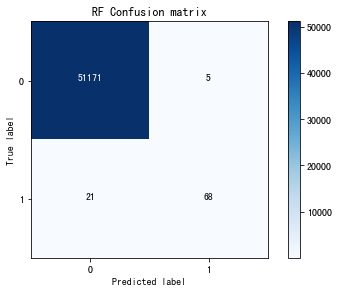

Precision =     0.932
Recall    =     0.764
F1_score  =     0.840


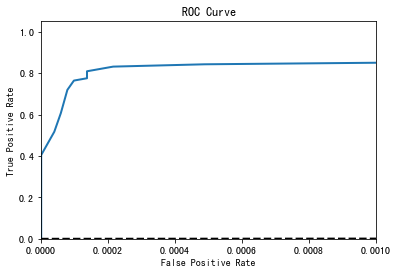

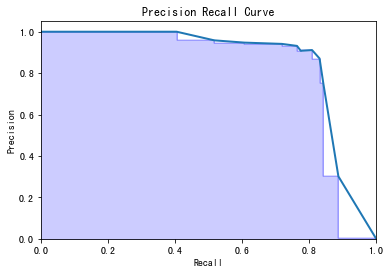

In [43]:
# 随机森林
rf_cfl = RandomForestClassifier(n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(X_train, y_train)
y_pred = rf_cfl.predict(X_test)
y_score = rf_cfl.predict_proba(X_test)[:,1]

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'RF Confusion matrix')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()


### 7.2 RF - GridSearchCV 搜索超参数

In [50]:
# 使用G ridSearchCV 搜索 RF 超参数
from sklearn.model_selection import GridSearchCV

param_grid = {
            'n_estimators': [100, 200, 500],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }

CV_rf_cfl = GridSearchCV(estimator = rf_cfl, param_grid = param_grid, scoring = 'f1', verbose = 10, n_jobs = -1)
CV_rf_cfl.fit(X_train, y_train)

best_parameters = CV_rf_cfl.best_params_
print("The best parameters for using this model is", best_parameters)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 69.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 87.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 106.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 129.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 152.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 176.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed

('The best parameters for using this model is', {'max_features': 3, 'min_samples_split': 5, 'n_estimators': 500, 'min_samples_leaf': 1})


### 7.3 RF - 超参数更新

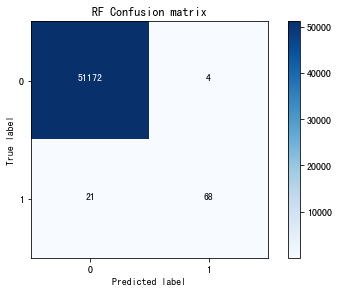

Precision =     0.944
Recall    =     0.764
F1_score  =     0.845


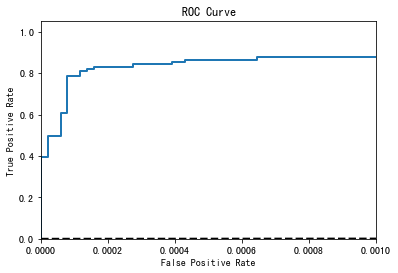

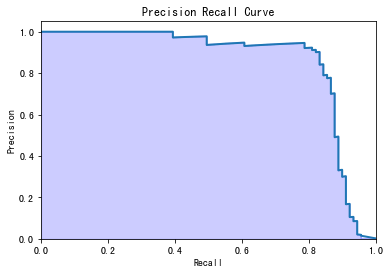

In [59]:
# 随机深林分类器
rf_cfl = RandomForestClassifier(n_estimators = 200, 
                                 max_features = 3, 
                                 min_samples_leaf = 1, 
                                 min_samples_split = 2, 
                                 n_jobs = -1,
                                random_state = 42)

rf_cfl.fit(X_train, y_train)
y_pred = rf_cfl.predict(X_test)
y_score = rf_cfl.predict_proba(X_test)[:,1]

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'RF Confusion matrix')
plt.savefig('3.rf_cfl_confusion_matrix.png')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_rf, tpr_rf, t_rf = fpr, tpr, t
precision_rf, recall_rf, thresholds_rf = precision, recall, thresholds

对特征重要程度可视化：

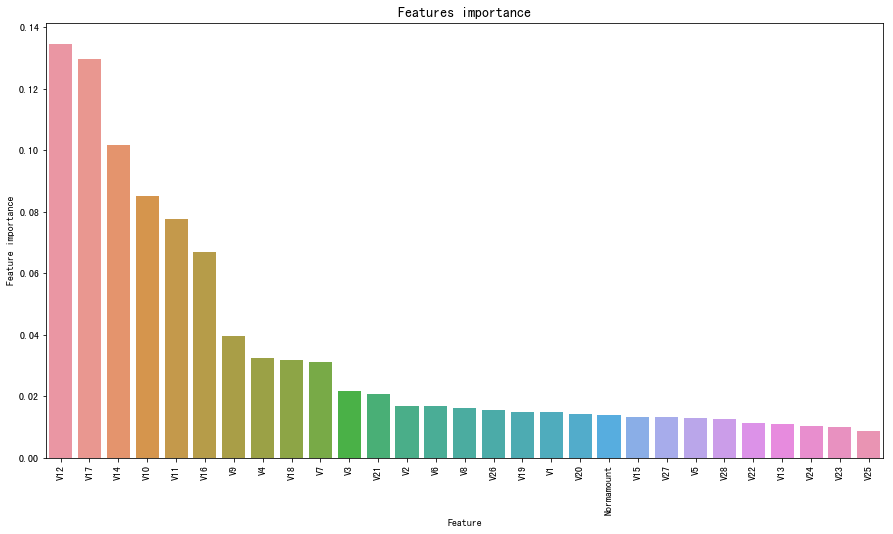

In [52]:
plot_feature_importance(rf_cfl)

## 8. VotingClassifier = LOG - XGB - RF (F1=0.881)

### 8.1 VotingClassfier

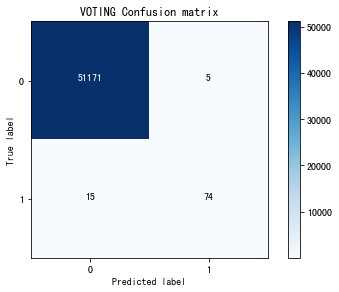

Precision =     0.937
Recall    =     0.831
F1_score  =     0.881


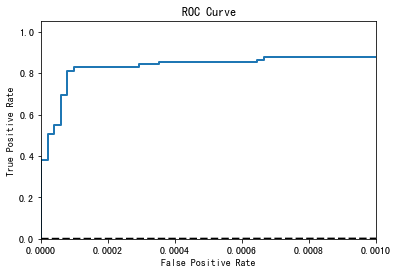

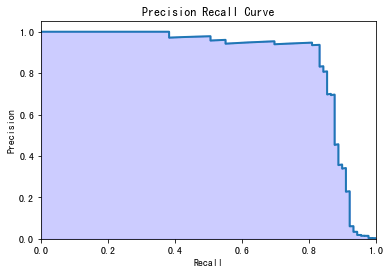

In [34]:
#Voting Classifier
voting_cfl = VotingClassifier (
        estimators = [('xgb', xgb_cfl), ('lt', log_cfl), ('rf', rf_cfl)],
                     voting='soft', weights = [1, 1, 1.33])
    
voting_cfl.fit(X_train,y_train)

y_pred = voting_cfl.predict(X_test)
y_score = voting_cfl.predict_proba(X_test)[:,1]

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'VOTING Confusion matrix')
plt.savefig('1.voting_confusion_matrix.png')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_voting, tpr_voting, t_voting = fpr, tpr, t
precision_voting, recall_voting, thresholds_voting = precision, recall, thresholds


### 8.2 Precision - Recall - Threshold 曲线

In [41]:
pr = 0.937
rec = 0.831
t = 0.5

# Precision-recall-threshold 曲线 : 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(16, 12))
    plt.title('Precision and Recall Scores (decision threshold)')
    plt.plot(thresholds, precisions[:-1], 'b-',linewidth=2, label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g', linewidth=2, label='Recall')
    plt.axvline(t, color='k', linestyle='--', label='Threshold')
    plt.axhline(pr, color='blue', linewidth=2, linestyle='--')
    plt.axhline(rec, color='green', linewidth=2, linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')
    plt.savefig('5.prec_recc_threshold.png')
    plt.show();

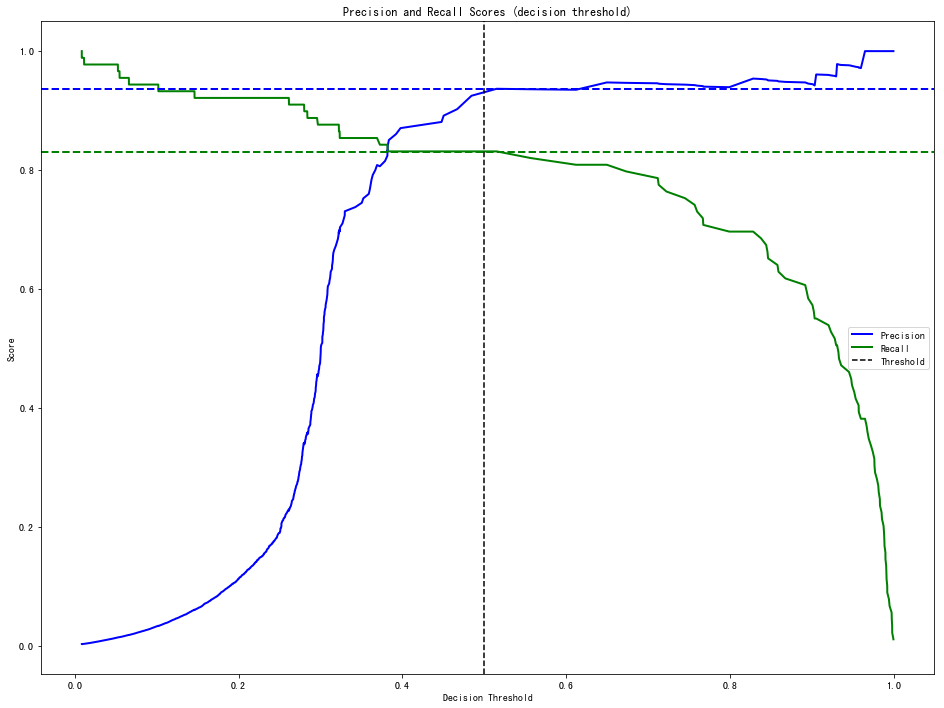

In [68]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

### 8.3 比较 ROC 曲线（所有模型）

In [37]:
def roc_curve_all_models(): 
    plt.figure(figsize=(16, 12))
    plt.plot(fpr_rf, tpr_rf, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_xgb, tpr_xgb, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_log, tpr_log, label = 'ROC curve', linewidth = 2)
    plt.plot(fpr_voting, tpr_voting, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(['Rnd','Xgb', 'Log', 'Voting'], loc='upper left')
    plt.savefig('6.roc.png')
    plt.show();

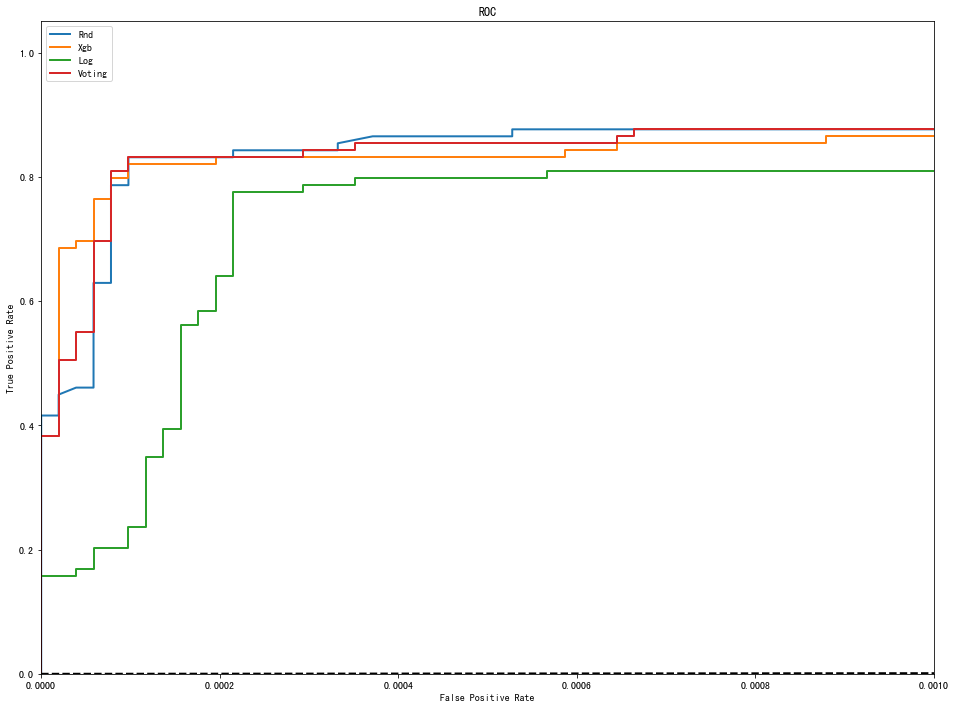

In [38]:
roc_curve_all_models ()

### 8.4 比较 Precision - Recall 曲线（所有模型）

In [39]:
def prec_recall_all_models():
    plt.figure(figsize=(16, 12))
    plt.plot(recall_rf, precision_rf, linewidth = 2)
    plt.plot(recall_xgb, precision_xgb, linewidth = 2)
    plt.plot(recall_log, precision_log, linewidth = 2)
    plt.plot(recall_voting, precision_voting, linewidth = 2)
    plt.scatter(rec, pr, linewidth = 2, color = 'red')
    plt.axvline(rec, color = 'red', linewidth = 1, linestyle='--')
    plt.axhline(pr, color = 'red', linewidth = 1, linestyle='--')
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve - PR = 0.937 - REC = 0.831 - F1 = 881 ')
    plt.legend(['Rnd', 'Xgb', 'Log', 'Voting'], loc='upper right')
    plt.savefig('7.prec_recc.png')
    plt.show();

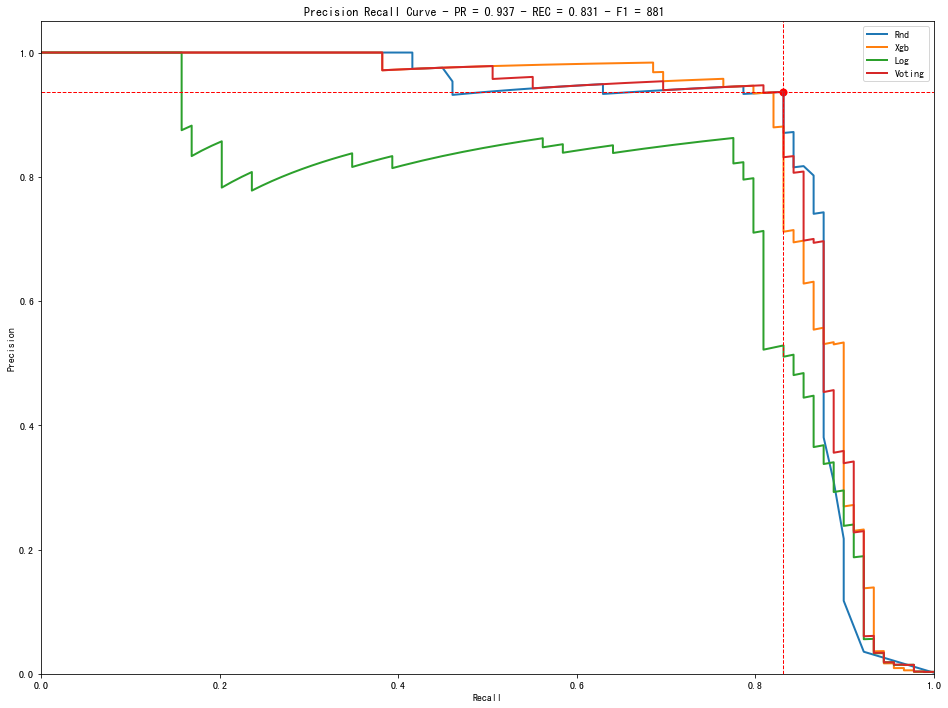

In [42]:
prec_recall_all_models () 

## 9. VotingClassfier: Validation (F1 = 0.884)

用测试集数据 test_data 评估模型性能

### 9.1 Amount归一化、去除无用变量并定义 X,y

In [43]:
# 归一化 Amount
from sklearn.preprocessing import StandardScaler
test_data['normAmount'] = StandardScaler().fit_transform(test_data['Amount'].values.reshape(-1,1))

In [52]:
# 删除 test_data 中的time和Amount 字段
test_data = test_data.drop(['Amount','Time'],axis=1)

In [55]:
# 定义 X & y
y = np.array(test_data.Class.tolist())
test_data = test_data.drop('Class', 1)
X = np.array(test_data.as_matrix())

print X_test.shape
print X.shape

(51265, 29)
(28481, 29)


### 9.2 VotingClassfier在测试集上的表现

In [56]:
y_pred = voting_cfl.predict(X)
y_score = voting_cfl.predict_proba(X)[:,1]

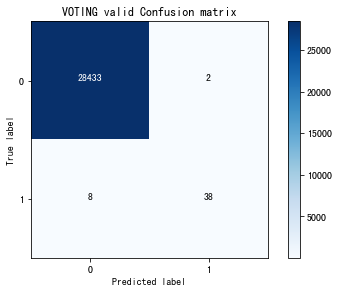

Precision =     0.950
Recall    =     0.826
F1_score  =     0.884


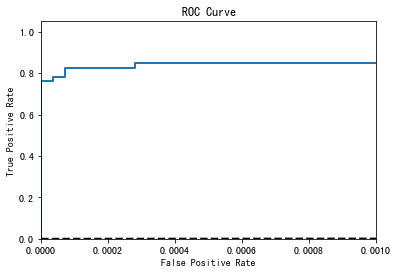

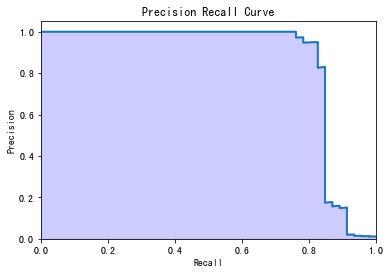

In [57]:
# 混淆矩阵
cm = confusion_matrix(y, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'VOTING valid Confusion matrix')
plt.savefig('8.votingvf_cfl_confusion_matrix.png')
plt.show()

show_metrics()

#ROC
fpr, tpr, t = roc_curve(y, y_score)
plot_roc()

#precision recall
precision, recall, thresholds = precision_recall_curve(y, y_score)
plot_precision_recall()

### 9.3 阈值选择

('F1_score w/ threshold = 0.1 :', 0.052336448598130844)
('F1_score w/ threshold = 0.2 :', 0.17391304347826086)
('F1_score w/ threshold = 0.3 :', 0.6046511627906976)
('F1_score w/ threshold = 0.4 :', 0.8444444444444444)
('F1_score w/ threshold = 0.5 :', 0.8837209302325583)
('F1_score w/ threshold = 0.6 :', 0.8674698795180723)
('F1_score w/ threshold = 0.7 :', 0.8641975308641976)
('F1_score w/ threshold = 0.8 :', 0.8354430379746834)
('F1_score w/ threshold = 0.9 :', 0.7567567567567568)


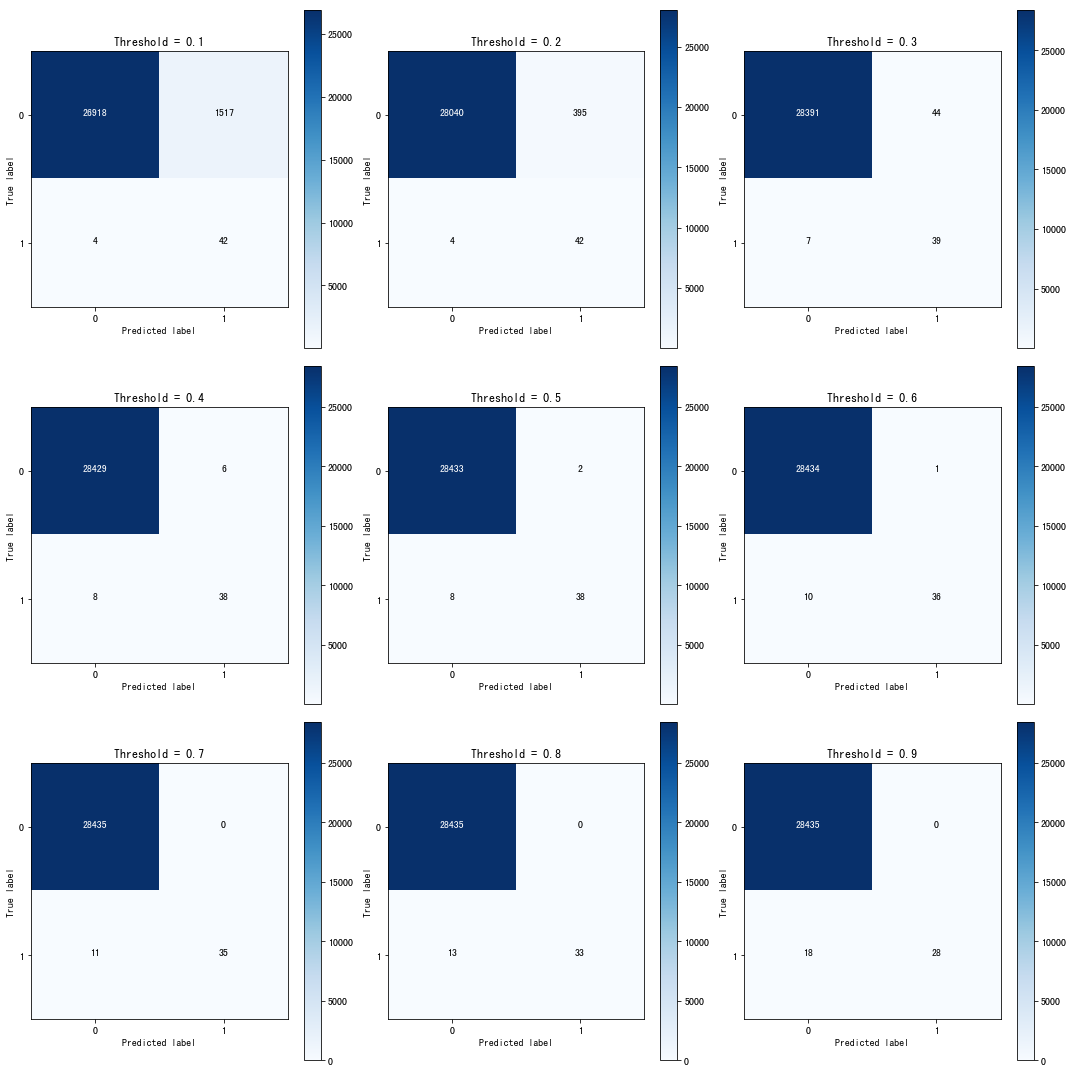

In [58]:
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = voting_cfl.predict_proba(X)[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('F1_score w/ threshold = %s :'%i, (2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 
    
plt.savefig('9.confusion_matrix_thresold_select.png')

可见阈值选择0.5时测试集上的 F1 值最大。